In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [2]:
def n_relation(a, b):
    assert a.shape == b.shape
    if (a == b).all() == True:
        return 'equal'
    elif (a <= b).all() and (a < b).any() == True:
        return 'less'
    elif (a >= b).all() and (a > b).any() == True:
        return 'more'
    else:
        return 'incomparable'
    
def b_transformed(b, pair):
    temp = b.copy()
    temp[pair[0]], temp[pair[1]] = temp[pair[1]], temp[pair[0]]
    return temp

def possible_permutation_indexes(b, A):
    return list(filter(lambda pair: b[pair[0]] > b[pair[1]], np.array(np.where(A == 1)).T))
    
def n_relation_with_pref(a, b, A):
    if (a == b).all() == True:
        return 'equal'
    elif n_relation(a, b) == 'less':
        return 'less'
    else:
        pairs = possible_permutation_indexes(b, A)
        if len(pairs) > 0:
            mutations = np.array([b_transformed(b, pair) for pair in pairs])
            relations = np.array([n_relation(a, mut) for mut in mutations])
            if (relations == 'less').any() == True:
                return 'less'
        else:
            return 'not related'
    
def relation_with_pref(a, b, A):
    assert a.shape == b.shape
    n_relation = n_relation_with_pref(a, b, A)
    if n_relation == 'equal' or n_relation == 'less':
        return n_relation
    else:
        reverse_check = n_relation_with_pref(b, a, A)
        if reverse_check == 'less':
            return 'more'
        else:
            return 'incomparable'

In [3]:
def optimal_Pareto_front(X):
    n = X.shape[0]
    front = [0]
    for i in range(1, n):
        t = X[i]
        relations = np.array([n_relation(t, X[ind]) for ind in front])
        
        if (relations == 'incomparable').all() or (relations == 'equal').any() == True:
            front.append(i)
        elif (relations == 'more').any() == True:
            bad_inds = np.array(np.where(relations == 'more')).reshape(-1)
            bad_items = []
            for bad_ind in bad_inds:
                bad_items.append(front[bad_ind])
            for bad_item in bad_items:
                front.remove(bad_item)
            front.append(i)
    
    rest = list(filter(lambda x: x not in front, np.arange(n)))
    
    return front, rest

def optimal_Pareto_front_with_pref(X, A):
    n = X.shape[0]
    front = [0]
    for i in range(1, n):
        t = X[i]
        relations = np.array([relation_with_pref(t, X[ind], A) for ind in front])
        
        if (relations == 'incomparable').all() or (relations == 'equal').any() == True:
            front.append(i)
        elif (relations == 'more').any() == True:
            bad_inds = np.array(np.where(relations == 'more')).reshape(-1)
            bad_items = []
            for bad_ind in bad_inds:
                bad_items.append(front[bad_ind])
            for bad_item in bad_items:
                front.remove(bad_item)
            front.append(i)
    
    rest = list(filter(lambda x: x not in front, np.arange(n)))
    
    return front, rest

In [4]:
def draw_vertical_line(start_point, end_y = -1, axis = None, c = 'red'):
    x = np.array([start_point[0], start_point[0]])
    y = np.array([start_point[1], end_y])
    if axis is not None:
        axis.plot(x, y, '--', color = c, alpha = 0.7)

def draw_horizontal_line(start_point, end_x = -1, axis = None , c = 'red'):
    x = np.array([start_point[0], end_x])
    y = np.array([start_point[1], start_point[1]])
    if axis is not None:
        axis.plot(x, y, '--', color = c, alpha = 0.7)

def draw_n_dominance_zone(a, axis, fill = True, c = 'red'):
    draw_vertical_line(a, axis = axis, c = c)
    draw_horizontal_line(a, axis = axis, c = c)
    if fill == True:
        axis.add_patch(Rectangle((-1, -1), a[0] + 1, a[1] + 1, facecolor = c, fill = True, alpha = 0.3))

In [5]:
def draw_POF(front_points, fill = True, c = 'red'):
    assert front_points[0].shape == (2,) 
    points = front_points[front_points[:,0].argsort()]
    
    point = points[0]
    draw_horizontal_line(point, c = c)
    
    if fill == True:
        ax.add_patch(Rectangle((-1, -1), point[0] + 1, point[1] + 1, facecolor = c, fill = True, alpha = 0.3))    
    
    for i in range(len(points) - 1):
        point = points[i]
        next_point = points[i+1]
        draw_vertical_line(point, next_point[1], c = c)
        draw_horizontal_line(next_point, point[0], c = c)
        
        if fill == True:
            len_x = next_point[0] - point[0]
            len_y = next_point[1] + 1
            ax.add_patch(Rectangle((point[0], -1), len_x, len_y, facecolor = c, fill = True, alpha = 0.3))  
        
    draw_vertical_line(points[-1], c = c)
    
def is_good(mut, points, A):
    relations = np.array([relation_with_pref(mut, point, A) for point in points])
    if ((relations == 'incomparable') | (relations == 'equal')).all() == True:
        return True
    else:
        return False
    
    
def draw_POF_with_pref(front_points, A, axis, fill = True, c = 'red'):
    
    assert front_points[0].shape == (2,) 
    if (A == 0).all():
        points = front_points
    
    elif A[0, 1] == 1:
        mutations = list(map(np.flip, filter(lambda point: point[0] > point[1], front_points)))
        good_mutations = np.array(list(filter(lambda mut: is_good(mut, front_points, A) == True, mutations)))
        if len(good_mutations) > 0:
            points = np.vstack((front_points, good_mutations))
        else:
            points = front_points
    elif A[1, 0] == 1:
        mutations = list(map(np.flip, filter(lambda point: point[1] > point[0], front_points)))
        good_mutations = np.array(list(filter(lambda mut: is_good(mut, front_points, A) == True, mutations)))
        if len(good_mutations) > 0:
            points = np.vstack((front_points, good_mutations))
        else:
            points = front_points
    
    points = points[points[:,0].argsort()]
       
    point = points[0]
    draw_horizontal_line(point, axis = axis, c = c)
    
    if fill == True:
        axis.add_patch(Rectangle((-1, -1), point[0] + 1, point[1] + 1, facecolor = c, fill = True, alpha = 0.3))    
    
    for i in range(len(points) - 1):
        point = points[i]
        next_point = points[i+1]
        draw_vertical_line(point, next_point[1], axis = axis, c = c)
        draw_horizontal_line(next_point, point[0], axis = axis, c = c)
        
        if fill == True:
            len_x = next_point[0] - point[0]
            len_y = next_point[1] + 1
            axis.add_patch(Rectangle((point[0], -1), len_x, len_y, facecolor = c, fill = True, alpha = 0.3))  
        
    draw_vertical_line(points[-1], axis = axis, c = c)

In [6]:
def Pareto_ranking(X):
    fronts = []
    f_ind, r_ind = optimal_Pareto_front(X)
    fronts.append(X[f_ind])
    while len(r_ind) > 0:
        X = X[r_ind]
        f_ind, r_ind = optimal_Pareto_front(X)
        fronts.append(X[f_ind])
    return fronts

def plot_Pareto_fronts(X, figsize = (6, 6)):
    fig, ax = plt.subplots(figsize = figsize)
    
    cmap = cm.gist_rainbow
    
    fronts = Pareto_ranking(X)
    
    for front, c in zip(fronts, range(len(fronts))):
        norm = Normalize(vmin=0, vmax=len(fronts) - 1)
        color = cmap(norm(c))
        draw_POF(front, fill = False, c = color)
        plt.scatter(front[:, 0], front[:, 1], color = color)
    
    plt.xlim(0, 4)
    plt.ylim(0, 4)
    plt.show()
    
def Pareto_ranking_with_pref(X, A):
    fronts = []
    f_ind, r_ind = optimal_Pareto_front_with_pref(X, A)
    fronts.append(X[f_ind])
    while len(r_ind) > 0:
        X = X[r_ind]
        f_ind, r_ind = optimal_Pareto_front_with_pref(X, A)
        fronts.append(X[f_ind])
    return fronts

def plot_Pareto_fronts_with_pref(X, A, axis):
    cmap = cm.gist_rainbow
    
    fronts = Pareto_ranking_with_pref(X, A)
    
    max_array = []
    for front, c in zip(fronts, range(len(fronts))):
        norm = Normalize(vmin=0, vmax=len(fronts) - 1)
        color = cmap(norm(c))
        draw_POF_with_pref(front, A, axis = axis, fill = False, c = color)
        axis.scatter(front[:, 0], front[:, 1], color = color, edgecolors = 'black')
        max_array.append(np.amax(front[:, 0]))
        max_array.append(np.amax(front[:, 1]))
    
    axis.set_xlim(0, np.amax(np.array(max_array)) + 1)
    axis.set_ylim(0, np.amax(np.array(max_array)) + 1)
    
    return fronts

In [12]:
def get_Pareto_rating(X, A, name = 'рейтинг'):
    fronts = Pareto_ranking_with_pref(X, A)
    rating = dict.fromkeys(names)
    for i, front in enumerate(fronts):
        for point in front:
            for ind in np.array(np.where(np.prod(X == point, axis = 1) == 1)).reshape(-1):
                key = names[ind]
                rating[key] = i+1

    df = pd.DataFrame.from_dict(rating, orient = 'index', columns = [name])
    return rating, df

def fill_na_1d(arr):
    med = int(round(np.median(arr[arr != None])))
    arr[arr == None] = med
    return np.array(arr, dtype = int)
def fill_na(arr):
    arr = np.array([fill_na_1d(np.array(row)) for row in arr])
    return arr

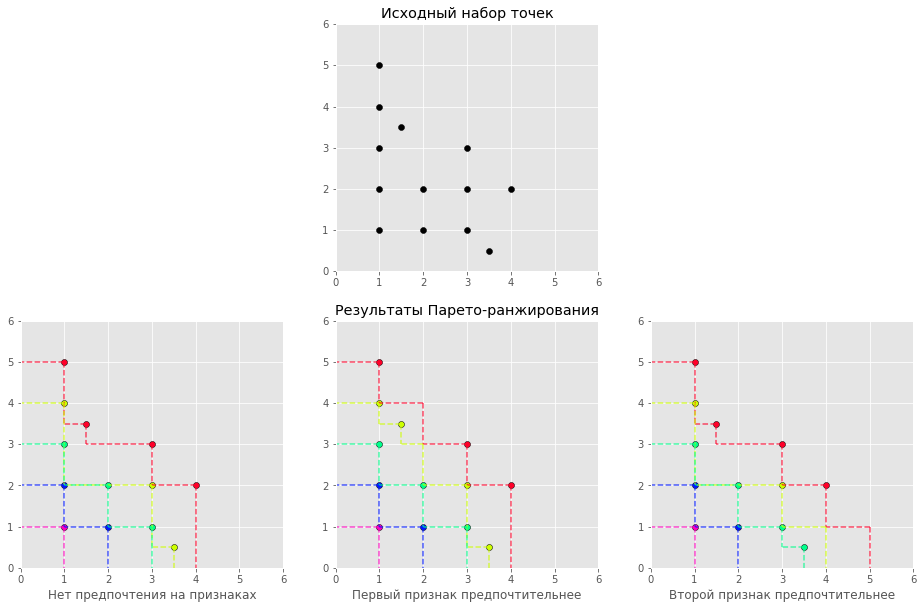

In [13]:
X = np.array([[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [2, 1], [2, 2], [3, 1],\
              [3, 2], [4, 2], [3, 3], [1.5, 3.5], [3.5, 0.5]])

A1 = np.array([[0, 0], [0, 0]])
A2 = np.array([[0, 1], [0, 0]])
A3 = np.array([[0, 0], [1, 0]])

fig, (ax1, ax2) = plt.subplots(2, 3, figsize = (16, 10))

ax1[0].axis('off')
ax1[1].scatter(X[:, 0], X[:, 1], color = 'black')
ax1[1].set_xlim(0, np.amax(X) + 1)
ax1[1].set_ylim(0, np.amax(X) + 1)
ax1[1].set_title('Исходный набор точек')
ax1[2].axis('off')

ax2[1].set_title('Результаты Парето-ранжирования')
plot_Pareto_fronts_with_pref(X, A1, axis = ax2[0])
ax2[0].set_xlabel('Нет предпочтения на признаках')
plot_Pareto_fronts_with_pref(X, A2, axis = ax2[1])
ax2[1].set_xlabel('Первый признак предпочтительнее')
plot_Pareto_fronts_with_pref(X, A3, axis = ax2[2])
ax2[2].set_xlabel('Второй признак предпочтительнее')

plt.show()

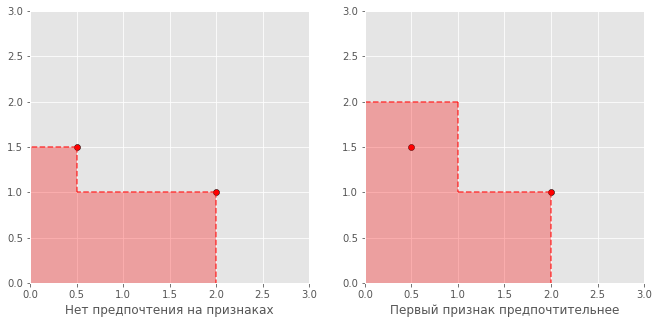

In [14]:
X = np.array([[2,1], [0.5, 1.5]])

A1 = np.array([[0, 0], [0, 0]])
A2 = np.array([[0, 1], [0, 0]])
A3 = np.array([[0, 0], [1, 0]])

front1, _ = optimal_Pareto_front_with_pref(X, A1)
front2, _ = optimal_Pareto_front_with_pref(X, A2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 5))
ax1.scatter(X[:, 0], X[:, 1], c = 'red', edgecolors = 'black')
ax2.scatter(X[:, 0], X[:, 1], c = 'red', edgecolors = 'black')
ax1.set_xlim(0, 3)
ax1.set_ylim(0, 3)
ax2.set_xlim(0, 3)
ax2.set_ylim(0, 3)
draw_POF_with_pref(X[front1], A1, axis = ax1)
ax1.set_xlabel('Нет предпочтения на признаках')
draw_POF_with_pref(X[front2], A2, axis = ax2)
ax2.set_xlabel('Первый признак предпочтительнее')


plt.show()

In [15]:
data = np.array([[72., 85., 9., 2., 4.4],
                 [640., 69., 25., 52., 17.],
                 [42., 5.9, 3.4, 2.5, 5.],
                 [371., 34., 3.6, 0.4, 20.],
                 [250., 8., 1., 3.2, 6.5],
                 [545., 100., 5., 33., 56.5],
                 [360.7, 35.6, 7.7, 19.1, 39.5],
                 [57, 5.9, 3, 3.2, 4],
                 [334, 4, 12, 2, 67]],)

experts = np.array([
    [4, None, None, None, 9, 5, None, None, None, None, 3, 9, 7, 6],
    [2, 6, 4, 8, 7, 4, 3, 3, None, 4, 6, 3, 4, 2],
    [5, 1, 5, 5, 4, 3, 8, 4, 2, 3, 5, 5, 6, None],
    [7, 7, 2, 3, 2, 8, 4, 6, 3, 5, None, 6, 5, 1],
    [None, 2, 7, 2, 6, 7, 5, 5, 7, None, 7, 7, 8, None],
    [3, 4, 1, 9, 5, None, 1, 1, 6, 6, 1, 2, 2, 4],
    [None, 3, 3, None, 1, 2, 6, 2, 1, 1, 2, 8, None, 5],
    [6, 5, 8, 4, 7, 1, 7, 7, 4, 7, None, 1, 1, None],
    [1, 8, 6, 1, 3, 6, 2, 8, 5, 2, 4, 4, 3, 3]
])
experts = 10 - fill_na(experts)

names = ['устрицы', 'арахис', 'молоко', 'макароны', 'молоко овс.', 'шоколад', 'cырок', 'кефир', 'греча']

In [16]:
experts

array([[6, 4, 4, 4, 1, 5, 4, 4, 4, 4, 7, 1, 3, 4],
       [8, 4, 6, 2, 3, 6, 7, 7, 6, 6, 4, 7, 6, 8],
       [5, 9, 5, 5, 6, 7, 2, 6, 8, 7, 5, 5, 4, 5],
       [3, 3, 8, 7, 8, 2, 6, 4, 7, 5, 5, 4, 5, 9],
       [3, 8, 3, 8, 4, 3, 5, 5, 3, 3, 3, 3, 2, 3],
       [7, 6, 9, 1, 5, 7, 9, 9, 4, 4, 9, 8, 8, 6],
       [8, 7, 7, 8, 9, 8, 4, 8, 9, 9, 8, 2, 8, 5],
       [4, 5, 2, 6, 3, 9, 3, 3, 6, 3, 4, 9, 9, 4],
       [9, 2, 4, 9, 7, 4, 8, 2, 5, 8, 6, 6, 7, 7]])

In [17]:
N = 10

a1 = data[:, 0] 
a1 = ((a1 - np.amin(a1))/(np.amax(a1) - np.amin(a1)) + 1/(N-1) ).round(2)*(N-1)
a2 = data[:, 1]
a2 = ((np.amax(a2) - a2)/(np.amax(a2) - np.amin(a2)) + 1/(N-1) ).round(2)*(N-1)
a3 = data[:, 2]
a3 = ((a3 - np.amin(a3))/(np.amax(a3) - np.amin(a3)) + 1/(N-1) ).round(2)*(N-1)
a4 = data[:, 3]
a4 = ((np.amax(a4) - a4)/(np.amax(a4) - np.amin(a4)) + 1/(N-1) ).round(2)*(N-1)
a5 = data[:, 4]
a5 = ((a5 - np.amin(a5))/(np.amax(a5) - np.amin(a5)) + 1/(N-1) ).round(2)*(N-1)

X = np.hstack((a1.reshape(-1, 1), a2.reshape(-1, 1), a3.reshape(-1, 1), a4.reshape(-1, 1), a5.reshape(-1, 1)))

X1 = X[:, 0:2]
X2 = X[:, 2:]

In [18]:
A1 = np.array([[0, 0], [1, 0]])
_, df1 = get_Pareto_rating(X1, A1, 'Рейтинг по соотношению калорийность-цена')
df1

,Рейтинг по соотношению калорийность-цена
устрицы,3
арахис,2
молоко,3
макароны,1
молоко овс.,2
шоколад,4
cырок,2
кефир,2
греча,1


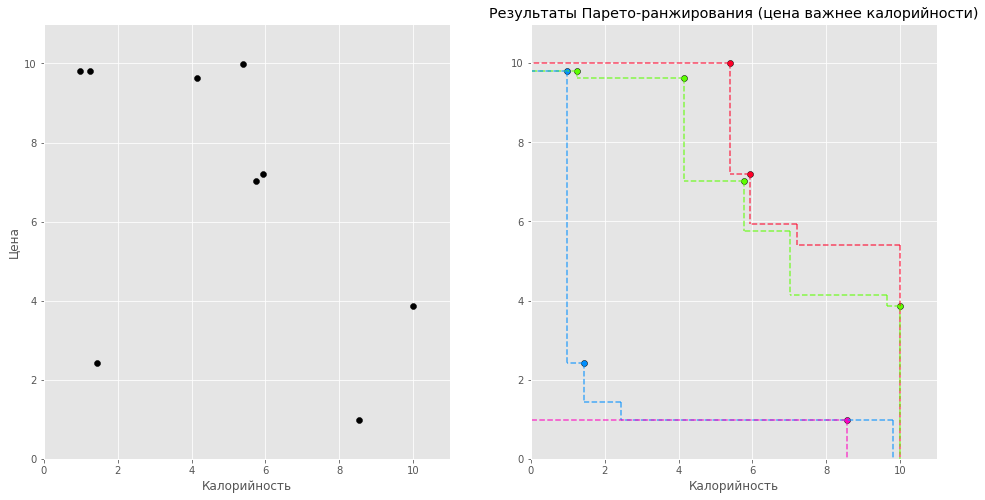

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))

ax1.scatter(X1[:, 0], X1[:, 1], color = 'black')
ax1.set_xlim(0, 11)
ax1.set_ylim(0, 11)
ax1.set_xlabel('Калорийность')
ax1.set_ylabel('Цена')

ax2.set_title('Результаты Парето-ранжирования (цена важнее калорийности)')
plot_Pareto_fronts_with_pref(X1, A1, axis = ax2)
ax2.set_xlabel('Калорийность')

plt.show()

In [20]:
A2 = np.array([[0, 1, 0], [0, 0, 0], [0, 1, 0]])

_, df2 = get_Pareto_rating(X2, A2, 'Рейтинг по соотношению б-ж-у')
df2

,Рейтинг по соотношению б-ж-у
устрицы,2
арахис,1
молоко,3
макароны,2
молоко овс.,3
шоколад,2
cырок,2
кефир,4
греча,1


In [21]:
r1 = df1.to_numpy()
r2 = df2.to_numpy()
alpha = 1
X_final = np.hstack((np.amax(r1) - r1 + 1, alpha*(np.amax(r2) - r2 + 1)))

In [22]:
A_final = np.array([[0, 0], [0, 0]])

rating_final, df_final = get_Pareto_rating(X_final, A_final, 'Итоговый рейтинг')
df_final

,Итоговый рейтинг
устрицы,4
арахис,2
молоко,5
макароны,2
молоко овс.,4
шоколад,5
cырок,3
кефир,5
греча,1


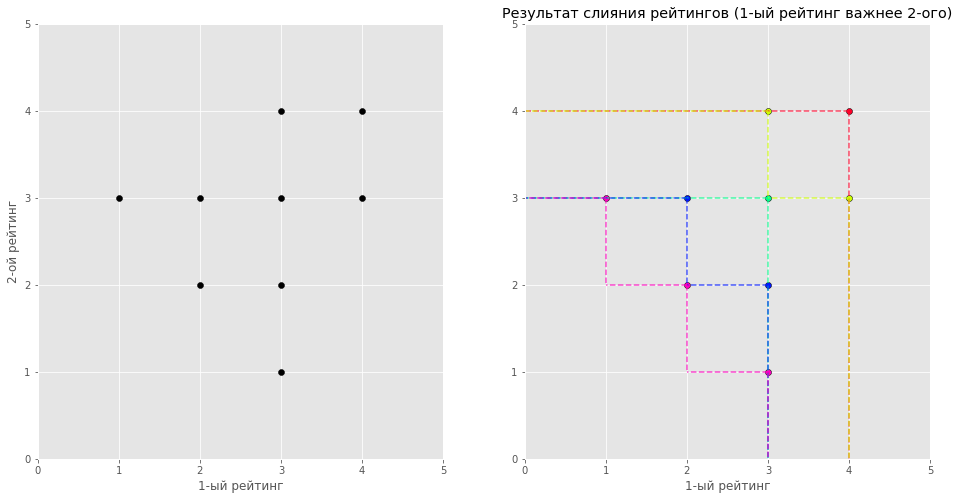

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))

ax1.scatter(X_final[:, 0], X_final[:, 1], color = 'black')
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 5)
ax1.set_xlabel('1-ый рейтинг')
ax1.set_ylabel('2-ой рейтинг')

ax2.set_title('Результат слияния рейтингов (1-ый рейтинг важнее 2-ого)')
plot_Pareto_fronts_with_pref(X_final, A_final, axis = ax2)
ax2.set_xlabel('1-ый рейтинг')

plt.show()

In [126]:
k = len(experts_filled)

A_exp = np.zeros((k, k))
#A_exp[4] += 1
#A_exp[4, 4] = 0

_, df_exp = get_Pareto_rating(experts, A_exp, 'Экспертный рейтинг')
df_exp 

,Экспертный рейтинг
устрицы,2
арахис,1
молоко,1
макароны,1
молоко овс.,1
шоколад,1
cырок,1
кефир,1
греча,1


In [24]:
def get_Pareto_rating_merged(X, start, end, name = 'рейтинг', plots = False):
    n = end - start
    if n <= 2:
        rating, df = get_Pareto_rating(X[:, start:(end+1)], np.zeros((n, n)), name = name)
    else:
        _, df1 = get_Pareto_rating_merged(X, start = start, end = start + n//2, plots = plots)
        _, df2 = get_Pareto_rating_merged(X, start = start + n//2 + 1, end = end, plots = plots)

        r1 = df1.to_numpy()
        r2 = df2.to_numpy()
        a1 = n//2 + 1
        a2 = end - start - n//2 - 1
        alpha1 = a1/(a1 + a2)
        alpha2 = a2/(a1 + a2)
        
        X_merged = np.hstack((alpha1*(np.amax(r1) - r1 + 1), alpha2*(np.amax(r2) - r2 + 1)))
        rating, df = get_Pareto_rating(X_merged, np.zeros((2, 2)), name = name)
        
    return rating, df

In [25]:
k = len(experts)

A_exp = np.zeros((k, k))

rating_exp, df_exp = get_Pareto_rating_merged(experts, start = 0, end = k-1, name = 'Экспертный рейтинг')
df_exp 

,Экспертный рейтинг
устрицы,5
арахис,4
молоко,2
макароны,3
молоко овс.,3
шоколад,2
cырок,1
кефир,3
греча,2


In [26]:
def get_Pareto_rating_sequential(X, end, name = 'рейтинг', plots = False):
    n = X.shape[1] - end
    assert n >= 1
    if end <= 1:
        rating, df = get_Pareto_rating(X[:, :(end+1)], np.zeros((n, n)), name = name)
    else:
        _, df1 = get_Pareto_rating_sequential(X, end = end-1, plots = plots)
        r1 = df1.to_numpy()
        r2 = X[:, end].reshape(-1, 1)
        X_sequenced = np.hstack((np.amax(r1) - r1 + 1, r2))
        rating, df = get_Pareto_rating(X_sequenced, np.zeros((2, 2)), name = name)
    return rating, df

In [29]:
k = len(experts)

A_exp = np.zeros((k, k))

_, df_exp_seq = get_Pareto_rating_sequential(np.flip(experts, axis = 1), end = k-1, name = 'Экспертный рейтинг (послед.)')
df_exp_seq

,Экспертный рейтинг (послед.)
устрицы,3
арахис,2
молоко,2
макароны,4
молоко овс.,4
шоколад,1
cырок,1
кефир,1
греча,3


In [30]:
r1 = df_final.to_numpy()
r2 = df_exp.to_numpy()
X_final_mb = np.hstack((np.amax(r1) - r1 + 1, np.amax(r2) - r2 + 1))

In [150]:
_, df_final_mb = get_Pareto_rating(X_final_mb, A_final, 'Итоговый рейтинг (мб)')
df_final_mb

,Итоговый рейтинг (мб)
устрицы,4
арахис,2
молоко,3
макароны,2
молоко овс.,3
шоколад,3
cырок,2
кефир,4
греча,1


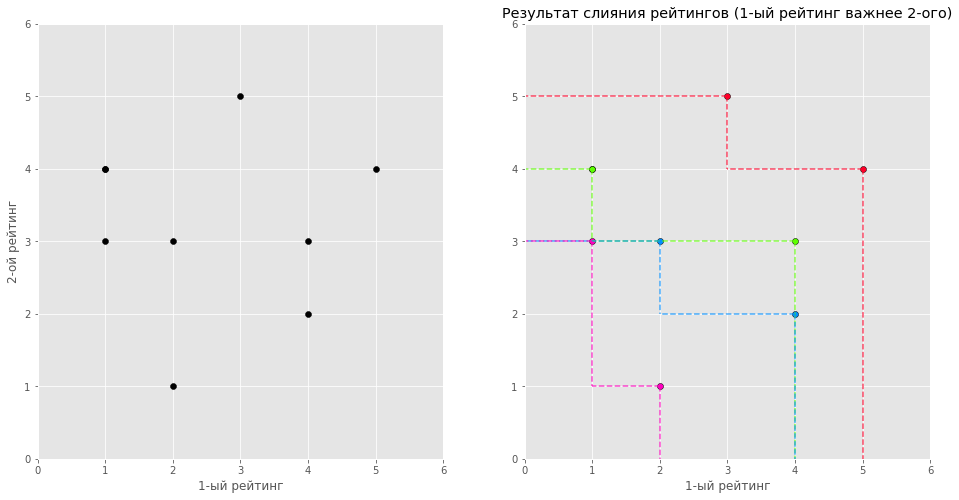

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))

ax1.scatter(X_final_mb[:, 0], X_final_mb[:, 1], color = 'black')
ax1.set_xlim(0, 6)
ax1.set_ylim(0, 6)
ax1.set_xlabel('1-ый рейтинг')
ax1.set_ylabel('2-ой рейтинг')

ax2.set_title('Результат слияния рейтингов (1-ый рейтинг важнее 2-ого)')
plot_Pareto_fronts_with_pref(X_final_mb, A_final, axis = ax2)
ax2.set_xlabel('1-ый рейтинг')

plt.show()

In [158]:
10 - experts.mean(axis = 1)

array([6.07142857, 4.28571429, 4.28571429, 4.57142857, 5.78571429,
       3.42857143, 3.07142857, 4.85714286, 4.        ])

In [32]:
k = len(experts)

A_exp = np.zeros((k, k))

rating_exp, df_exp = get_Pareto_rating_merged(experts, start = 0, end = k-1, name = 'Экспертный рейтинг')
df_exp 

,Экспертный рейтинг
устрицы,5
арахис,4
молоко,2
макароны,3
молоко овс.,3
шоколад,2
cырок,1
кефир,3
греча,2


In [37]:
np.sum(experts, axis = 1)

array([ 55,  80,  79,  76,  56,  92, 100,  70,  84])

In [33]:
r1 = df_final.to_numpy()
r2 = df_exp.to_numpy()
alpha1 = 1
alpha2 = 5
X_final_mb = np.hstack((alpha1*(np.amax(r1) - r1 + 1), alpha2*(np.amax(r2) - r2 + 1)))

In [34]:
A_final = np.array([[0, 0], [1, 0]])

_, df_final_mb = get_Pareto_rating(X_final_mb, A_final, 'Итоговый рейтинг (мб)')
df_final_mb

,Итоговый рейтинг (мб)
устрицы,4
арахис,3
молоко,2
макароны,2
молоко овс.,3
шоколад,2
cырок,1
кефир,4
греча,1


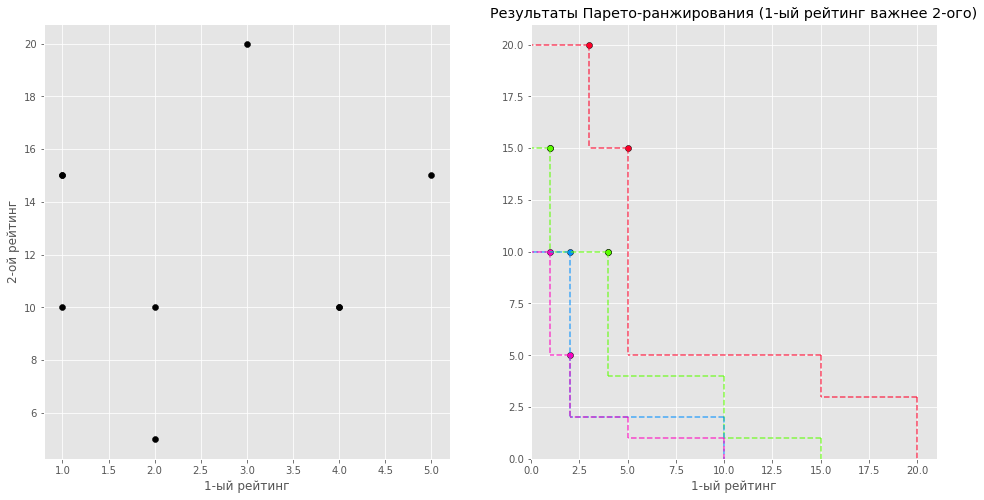

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))

ax1.scatter(X_final_mb[:, 0], X_final_mb[:, 1], color = 'black')
#ax1.set_xlim(0, 6)
#ax1.set_ylim(0, 6)
ax1.set_xlabel('1-ый рейтинг')
ax1.set_ylabel('2-ой рейтинг')

ax2.set_title('Результаты Парето-ранжирования (1-ый рейтинг важнее 2-ого)')
plot_Pareto_fronts_with_pref(X_final_mb, A_final, axis = ax2)
ax2.set_xlabel('1-ый рейтинг')

plt.show()

In [38]:
np.sum(experts, axis = 1)

array([ 55,  80,  79,  76,  56,  92, 100,  70,  84])

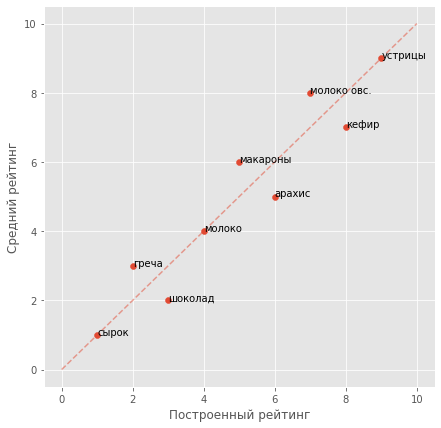

In [66]:
names = ['устрицы', 'арахис', 'молоко', 'макароны', 'молоко овс.', 'шоколад', 'сырок', 'кефир', 'греча']

r1 = np.array([9, 6, 4, 5, 7, 3, 1, 8, 2])
r2 = np.array([9, 5, 4, 6, 8, 2, 1, 7, 3])

x = np.array([0,10])


plt.figure(figsize = (7,7))
plt.plot(x, x, '--', alpha = 0.5)
plt.scatter(r1, r2)
for i, name in enumerate(names):
    plt.text(r1[i], r2[i], name)
plt.xlabel('Построенный рейтинг')
plt.ylabel('Средний рейтинг')
plt.show()

In [39]:
experts

array([[6, 4, 4, 4, 1, 5, 4, 4, 4, 4, 7, 1, 3, 4],
       [8, 4, 6, 2, 3, 6, 7, 7, 6, 6, 4, 7, 6, 8],
       [5, 9, 5, 5, 6, 7, 2, 6, 8, 7, 5, 5, 4, 5],
       [3, 3, 8, 7, 8, 2, 6, 4, 7, 5, 5, 4, 5, 9],
       [3, 8, 3, 8, 4, 3, 5, 5, 3, 3, 3, 3, 2, 3],
       [7, 6, 9, 1, 5, 7, 9, 9, 4, 4, 9, 8, 8, 6],
       [8, 7, 7, 8, 9, 8, 4, 8, 9, 9, 8, 2, 8, 5],
       [4, 5, 2, 6, 3, 9, 3, 3, 6, 3, 4, 9, 9, 4],
       [9, 2, 4, 9, 7, 4, 8, 2, 5, 8, 6, 6, 7, 7]])

In [43]:
from scipy.stats import kendalltau

k = experts.shape[1]

coefs = [[kendalltau(experts[:, i], experts[:, j])[0] for j in range(k)] for i in range(k)]
coefs_array = np.array(coefs)

In [44]:
coefs_array.shape

(14, 14)

In [61]:
coefs = np.sum(coefs_array, axis = 1)

In [62]:
A_exp = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        if coefs[i] > coefs[j]:
            A_exp[i][j] += 1

In [63]:
A_exp

array([[0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
       [0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
       [1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.]])

In [50]:
_, df_exp_with_pref = get_Pareto_rating(experts, A_exp, 'Экспертный рейтинг')
df_exp_with_pref 

,Экспертный рейтинг
устрицы,2
арахис,1
молоко,1
макароны,1
молоко овс.,1
шоколад,1
сырок,1
кефир,1
греча,1


In [55]:
def get_Pareto_rating_merged_with_pref(X, start, end, A, name = 'рейтинг', plots = False):
    n = end - start
    if n <= 2:
        rating, df = get_Pareto_rating(X[:, start:(end+1)], A[start:end+1, start:end+1], name = name)
    else:
        _, df1 = get_Pareto_rating_merged(X, start = start, end = start + n//2, plots = plots)
        _, df2 = get_Pareto_rating_merged(X, start = start + n//2 + 1, end = end, plots = plots)

        r1 = df1.to_numpy()
        r2 = df2.to_numpy()
        a1 = n//2 + 1
        a2 = end - start - n//2 - 1
        alpha1 = a1/(a1 + a2)
        alpha2 = a2/(a1 + a2)
        
        X_merged = np.hstack((alpha1*(np.amax(r1) - r1 + 1), alpha2*(np.amax(r2) - r2 + 1)))
        rating, df = get_Pareto_rating(X_merged, np.zeros((2, 2)), name = name)
        
    return rating, df

In [56]:
rating_exp, df_exp_merged_with_pref = get_Pareto_rating_merged_with_pref(experts, 0, k-1, A_exp, name = 'Экспертный рейтинг')
df_exp_merged_with_pref

,Экспертный рейтинг
устрицы,4
арахис,2
молоко,2
макароны,2
молоко овс.,4
шоколад,1
сырок,1
кефир,3
греча,1


In [57]:
r1 = df_final.to_numpy()
r2 = df_exp.to_numpy()
alpha1 = 1
alpha2 = 1
#alpha2 = 5
X_final_mb = np.hstack((alpha1*(np.amax(r1) - r1 + 1), alpha2*(np.amax(r2) - r2 + 1)))

In [58]:
A_final = np.array([[0, 0], [1, 0]])

_, df_final_mb = get_Pareto_rating(X_final_mb, A_final, 'Итоговый рейтинг (мб)')
df_final_mb

,Итоговый рейтинг (мб)
устрицы,5
арахис,3
молоко,2
макароны,2
молоко овс.,3
шоколад,2
сырок,1
кефир,4
греча,1


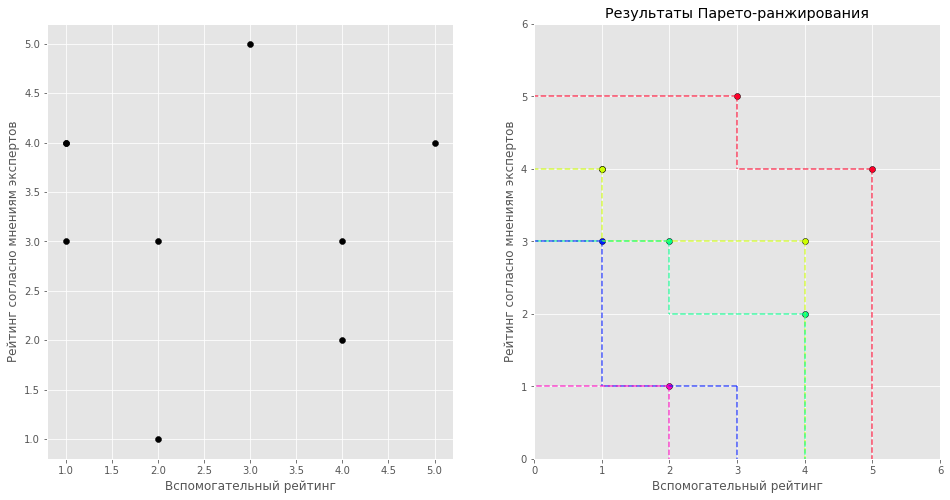

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))

ax1.scatter(X_final_mb[:, 0], X_final_mb[:, 1], color = 'black')
#ax1.set_xlim(0, 6)
#ax1.set_ylim(0, 6)
ax1.set_xlabel('Вспомогательный рейтинг')
ax1.set_ylabel('Рейтинг согласно мнениям экспертов')

ax2.set_title('Результаты Парето-ранжирования')
plot_Pareto_fronts_with_pref(X_final_mb, A_final, axis = ax2)
ax2.set_ylabel('Рейтинг согласно мнениям экспертов')
ax2.set_xlabel('Вспомогательный рейтинг')

plt.show()

In [59]:
B = np.array([[1, 3], [2, 4], [3, 5]])
c = np.array([0.5, 0.5])

B*c

array([[0.5, 1.5],
       [1. , 2. ],
       [1.5, 2.5]])

In [65]:
np.sum(experts*coefs, axis = 1)

array([147.20121693, 222.08836266, 206.70933913, 207.92101074,
       121.86428522, 255.17078501, 276.98853793, 173.56660648,
       223.46629057])

In [ ]:
names = ['устрицы', 'арахис', 'молоко', 'макароны', 'молоко овс.', 'шоколад', 'сырок', 'кефир', 'греча']